<a href="https://colab.research.google.com/github/yfhkucing/experiment_bms/blob/master/Heatmap_with_model_154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import joblib
import numpy as np
import pandas as pd

In [3]:
! unzip /content/models_temp_154_a0005.zip

Archive:  /content/models_temp_154_a0005.zip
replace content/models/model 44? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/models/model 44  
  inflating: content/models/model 107  
  inflating: content/models/model 43  
  inflating: content/models/model 117  
  inflating: content/models/model 25  
  inflating: content/models/model 126  
  inflating: content/models/model 100  
  inflating: content/models/model 81  
  inflating: content/models/model 68  
  inflating: content/models/model 18  
  inflating: content/models/model 75  
  inflating: content/models/model 106  
  inflating: content/models/model 102  
  inflating: content/models/model 27  
  inflating: content/models/model 59  
  inflating: content/models/model 86  
  inflating: content/models/model 112  
  inflating: content/models/model 96  
  inflating: content/models/model 4  
  inflating: content/models/model 40  
  inflating: content/models/model 136  
  inflating: content/models/model 23  
  inflating: cont

In [4]:
feature = pd.read_excel('data_model.xlsx',sheet_name='feature')
label = pd.read_excel('data_model.xlsx',sheet_name='label_154')

In [5]:
def norm(df):
  df=(df-df.min())/(df.max()-df.min())
  return df

def remap(df,new_max,new_min):
  df = (df-df.min())/(df.max()-df.min())*(new_max - new_min) + new_min
  return df

from sklearn.preprocessing import StandardScaler
def standard(df):
  scaler = StandardScaler()
  df = scaler.fit_transform(df)
  return df

def rescale(df,df2):
  new_max = df2.max()
  new_min = df2.min()
  df = (df)*(new_max - new_min) + new_min
  return df

In [6]:
feature = norm(feature)

In [7]:
array_y = []
array_y_not_normal = []
for i in range(154):
  frame= label[i::154]
  frame = frame.drop(['koor_x','koor_y',],axis=1)
  frame = frame.drop(['Vx','Vy'],axis=1)
  array_y_not_normal.append(frame)
  frame = norm(frame)
  array_y.append(frame)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

skor_r2=[]
mae_=[]
rmse = []
y_predict = []
y_test = []
for i in range(154):
  x = np.array(feature)
  y = np.array(array_y[i])
  model = joblib.load(f'/content/content/models/model {i}')
  y_pred = model.predict(x)
  Skor_r2 = r2(y,y_pred)
  RMSE = mse(y,y_pred,squared=False)
  MAE = mae(y,y_pred)
  y_predict.append(y_pred)
  skor_r2.append(Skor_r2)
  mae_.append(MAE)
  rmse.append(RMSE)

In [9]:
skor_r2 = np.array(skor_r2)
rmse = np.array(rmse)
mae_=np.array(mae_)
y_predict = np.array(y_predict)
y = np.array(array_y)

In [10]:
#error per skenario

r_squared = []
abs_error = []
sqrt_error = []
for i in range(192):
  a = y[...,i,0]
  b = y_predict[...,i]
  r_squared.append(r2(a,b))
  abs_error.append(mae(a,b))
  sqrt_error.append(mse(a,b))

In [11]:
error = pd.DataFrame(r_squared,columns=['r2'])
abs_error = pd.DataFrame(abs_error,columns=['mae'])
sqrt_error = pd.DataFrame(sqrt_error,columns=['rmse'])
error = error.join(abs_error)
error = error.join(sqrt_error)

In [12]:
df_koor = pd.read_excel('data_model.xlsx',sheet_name='koordinat_154_aktual')

In [13]:
df_y = []
df_y_predict = []
for i in range(30):
  q = pd.DataFrame(y[i],columns=['Temp'])
  q = round(rescale(q,array_y_not_normal[i]),9)
  df_y.append(q)
  r = round(pd.DataFrame(y_predict[i],columns=['Temp']),9)
  r = rescale(r,array_y_not_normal[i])
  df_y_predict.append(r)

In [14]:
def suhu(y,scenarios):
  df_x = pd.DataFrame(y[...,scenarios,0])
  df_x = df_x.join(df_koor)
  df_x.rename(columns={0:'Temp'},inplace=True)
  return df_x

In [15]:
#error per skenario

r_squared = []
abs_error = []
sqrt_error = []
indexing = 0,1
for i in range(192):
  a = suhu(np.array(df_y),i)
  a.drop(['koor_x','koor_y'],axis=1)
  b = suhu(np.array(df_y_predict),i)
  b.drop(['koor_x','koor_y'],axis=1)
  r_squared.append(r2(a,b))
  abs_error.append(mae(a,b))
  sqrt_error.append(mse(a,b))

error = pd.DataFrame(r_squared,columns=['r2'])
abs_error = pd.DataFrame(abs_error,columns=['mae'])
sqrt_error = pd.DataFrame(sqrt_error,columns=['rmse'])
error = error.join(abs_error)
error = error.join(sqrt_error)

In [16]:
error.describe()

,r2,mae,rmse
count,192.000000,192.000000,192.000000
mean,-0.802768,0.444143,0.949362
std,2.323199,0.310818,1.056524
min,-11.383180,0.046661,0.009099
25%,-1.305173,0.137694,0.079612
50%,-0.038922,0.390784,0.476244
75%,0.805609,0.703323,1.588381
max,0.985565,1.191222,4.368936


In [17]:
min_error = error[error.r2 == error.r2.max()]
min_error

,r2,mae,rmse
82,0.985565,0.048941,0.011141


In [18]:
max_error = error[error.r2 == error.r2.min()]
max_error

,r2,mae,rmse
153,-11.38318,0.808134,2.035737


In [19]:
writer = pd.ExcelWriter('temp_30_a00001.xlsx')

# Write each dataframe to a different worksheet.
error.to_excel(writer, sheet_name='metric',index=False)
error.describe().to_excel(writer, sheet_name='metric summary',index=False)
min_error.to_excel(writer, sheet_name='minimum error',index=False)
max_error.to_excel(writer, sheet_name='maximum error',index=False)

# Close the Pandas Excel writer and output the Excel file.
#writer.save()

In [20]:
r2_matrix = skor_r2.reshape(11,14)
rmse_matrix = rmse.reshape(11,14)
mae_matrix = mae_.reshape(11,14)

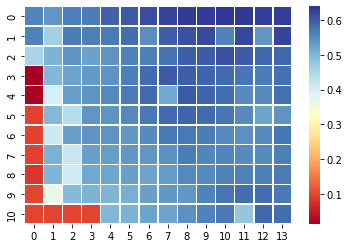

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(r2_matrix, linewidth=0.5, cmap="RdYlBu")
plt.show()

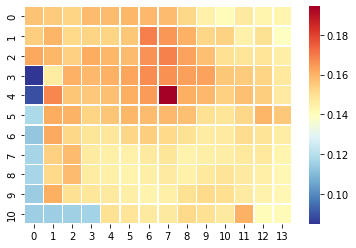

In [22]:
bx = sns.heatmap(rmse_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

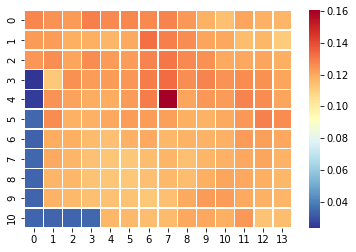

In [23]:
bx = sns.heatmap(mae_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

In [24]:
! mkdir subplot

mkdir: cannot create directory ‘subplot’: File exists


In [25]:
'''
def suhu(y):
  df_y = pd.DataFrame(y)
  df_z = pd.DataFrame(y)
  df_z.rename(columns={0:1},inplace=True)
  df_y = df_y.join(df_z)
  df_y = df_y.join(df_koor)
  df_y.rename(columns={0:'Vx',1:'suhu'},inplace=True)
  df_y.pop('Vx')
  return df_y
'''

"\ndef suhu(y):\n  df_y = pd.DataFrame(y)\n  df_z = pd.DataFrame(y)\n  df_z.rename(columns={0:1},inplace=True)\n  df_y = df_y.join(df_z)\n  df_y = df_y.join(df_koor)\n  df_y.rename(columns={0:'Vx',1:'suhu'},inplace=True)\n  df_y.pop('Vx')\n  return df_y\n"

In [26]:
def suhu(y):
  df_y = pd.DataFrame(y)
  df_z = pd.DataFrame(y)
  df_z.rename(columns={0:1},inplace=True)
  df_y = df_y.join(df_z)
  df_y = df_y.join(df_koor)
  df_y.rename(columns={0:'Vx',1:'suhu'},inplace=True)
  df_y.pop('Vx')
  return df_y

In [27]:
from plotly.subplots import make_subplots
for i in range(192):
  a = y[(...,i,0)]
  b = y_predict[(...,i)]
  a = np.array(a)
  b = np.array(b)
  a = suhu(a)
  b = suhu(b)
  
  fig = make_subplots(rows=1, cols=2)

  fig.add_contour(
     z = a['suhu'].tolist(),
     x = a['koor_x'].tolist(),
     y = a['koor_y'].tolist(),
     row=1, col=1
  )

  fig.add_contour(
     z = b['suhu'].tolist(),
     x = b['koor_x'].tolist(),
     y = b['koor_y'].tolist(),
     row=1, col=2
  )
  fig.write_image(f'/content/subplot/fig {i}.png')

In [28]:
!zip -r /content/subplot.zip /content/subplot

updating: content/subplot/ (stored 0%)
updating: content/subplot/fig 135.png (deflated 5%)
updating: content/subplot/fig 168.png (deflated 4%)
updating: content/subplot/fig 154.png (deflated 4%)
updating: content/subplot/fig 79.png (deflated 4%)
updating: content/subplot/fig 71.png (deflated 4%)
updating: content/subplot/fig 15.png (deflated 4%)
updating: content/subplot/fig 110.png (deflated 8%)
updating: content/subplot/fig 146.png (deflated 4%)
updating: content/subplot/fig 118.png (deflated 5%)
updating: content/subplot/fig 53.png (deflated 4%)
updating: content/subplot/fig 38.png (deflated 3%)
updating: content/subplot/fig 151.png (deflated 4%)
updating: content/subplot/fig 123.png (deflated 5%)
updating: content/subplot/fig 188.png (deflated 5%)
updating: content/subplot/fig 5.png (deflated 5%)
updating: content/subplot/fig 43.png (deflated 3%)
updating: content/subplot/fig 88.png (deflated 4%)
updating: content/subplot/fig 12.png (deflated 4%)
updating: content/subplot/fig 132.p